# Product Recommendation

In [1]:
import numpy as np
import pandas as pd
from customized import preprocess
from customized import metrics
from customized import end2end_recommendation
from striatum import MAB
from striatum.storage.action import Action
from neural_exploration import neuralucb_main
# import importlib
# importlib.reload(end2end_recommendation)

### with class weights

[Autoencode streamer-product features]
[Test] change Double to Float
Step [8/8], Reconstructed Loss: 0.0230
product feature: (1023, 32)
streamer feature: (1023, 23)
small streamer-product: (1023, 55)
total: 2661846, pos: 12265, neg: 2649581
Weight for class 0: 0.50
Weight for class 1: 108.51


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:38 Time:  0:00:38


Recommend Ratio: 99.88 %
Accuracy: 4.04 %
tp: 102
tn: 3
fp: 2497
fn: 0
Precision: 3.92 %
Recall: 100.00 %
Correct: 105
Regret: 95.96 %
Early Stop times: 36


100% (2602 of 2602) |####################| Elapsed Time: 0:00:41 Time:  0:00:41


Recommend Ratio: 99.15 %
Accuracy: 3.31 %
tp: 64
tn: 22
fp: 2516
fn: 0
Precision: 2.48 %
Recall: 100.00 %
Correct: 86
Regret: 96.69 %
Early Stop times: 25


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:51 Time:  0:00:51


Recommend Ratio: 100.00 %
Accuracy: 0.27 %
tp: 7
tn: 0
fp: 2595
fn: 0
Precision: 0.27 %
Recall: 100.00 %
Correct: 7
Regret: 99.73 %
Early Stop times: 48


100% (2602 of 2602) |####################| Elapsed Time: 0:00:50 Time:  0:00:50


Recommend Ratio: 100.00 %
Accuracy: 0.35 %
tp: 9
tn: 0
fp: 2593
fn: 0
Precision: 0.35 %
Recall: 100.00 %
Correct: 9
Regret: 99.65 %
Early Stop times: 55
aenn's regret: 95.9646 %
vaenn's regret: 96.6949 %
aebnn's regret: 99.731 %
vaebnn's regret: 99.6541 %


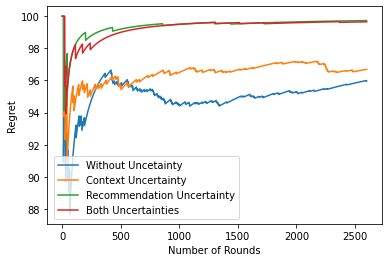

aenn's coverage: 0.8316 %
vaenn's coverage: 0.5218 %
aebnn's coverage: 0.0571 %
vaebnn's coverage: 0.0734 %


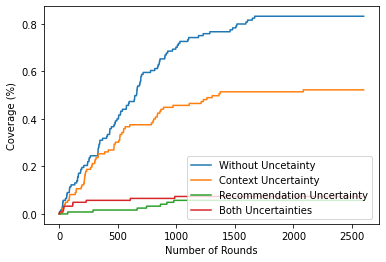

aenn's diversity: 23.9492 %
vaenn's diversity: 31.9648 %
aebnn's diversity: 65.2004 %
vaebnn's diversity: 87.8788 %


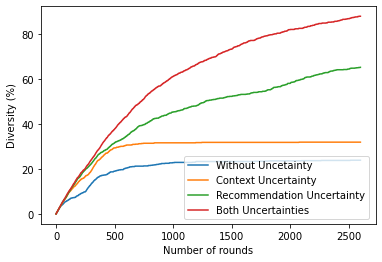

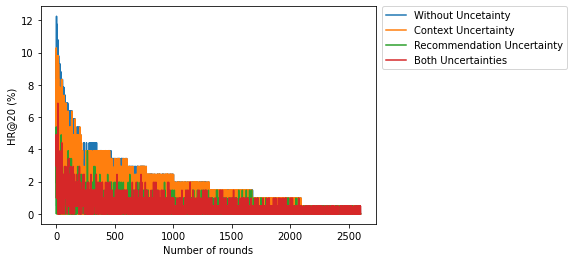

aenn's hit ratio: 64.1419 %
vaenn's hit ratio: 51.0722 %
aebnn's hit ratio: 17.2197 %
vaebnn's hit ratio: 19.201 %


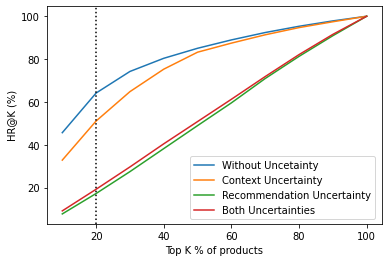

In [2]:
experiments = ['aenn', 'vaenn', 'aebnn', 'vaebnn']
mylabels = ['Without Uncetainty', 'Context Uncertainty', 'Recommendation Uncertainty', 'Both Uncertainties']
fig_name = 'end2end_lers_structure_big_weights'

regrets_structure_w, hr_structure_w, coverage_structure_w, diversity_structure_w, \
all_reward_pivot, cust_id, reward_cust_id, reward_prod_id, highest_idxs = \
    end2end_recommendation.main(experiments, mylabels, fig_name, 2602, 1023, z_dim=20, weight_eps=1, class_weight = True)

# MAB

In [3]:
# import importlib
# importlib.reload(MAB)
def main(num, full_context, context_id, rewards, reward_prod_id, lers_regret, lers_hr, lers_coverage, lers_diversity): # 2602人, 815dim
    
    actions = []
    for prod_id in reward_prod_id:
        action = Action(int(prod_id))
        actions.append(action)
    user_features = pd.DataFrame(np.array(full_context), index=context_id)
    all_rewards_df = pd.melt(rewards, ignore_index=False, var_name='商品id', value_name='reward')\
                    .loc[context_id].reset_index()
    print(f"user features: {user_features.shape}, reward targets: {rewards.shape}")
    
    experiment_bandit = ['aenn','vaenn','aebnn','vaebnn','UCB1', 'LinUCB', 'Exp3', 'NeuralUCB','random']
    mab_bandit = ['random', 'UCB1', 'LinUCB', 'Exp3']
    predict_id = {}
    rec_id = {}
    regret = {}
    hr = {}
    topk = {}
    coverage_dict = {} 
    diversity_dict = {}
    mylabels = ['LERS (Without Uncertainty)','LERS (Context Uncertainty)','LERS (Recommendation Uncertainty)', 'LERS (Both Uncertainties)',\
               'UCB1', 'LinUCB', 'Exp3', 'NeuralUCB', 'Random']

    for bandit in experiment_bandit:   
        print("-----")
        print(bandit)
        if bandit in mab_bandit:      
            policy = MAB.policy_generation(bandit, actions)
            seq_error, rec_id[bandit], predict_id[bandit] = MAB.policy_evaluation(policy, bandit, num, user_features, rewards, actions, len(actions))
            regret[bandit] = MAB.regret_calculation(seq_error)
            if bandit != 'random':
                hr[bandit], k_list, topk[bandit] = metrics.cal_hit_ratio_mab(num, all_rewards_df, predict_id[bandit], min_val=10, max_val=110, step=10)
            # coverage
            coverage_dict[bandit] = MAB.cal_coverage_non_repeat(all_rewards_df, rewards, rec_id[bandit])
            # diversity
            diversity_dict[bandit] = metrics.cal_diversity(len(actions), rec_id[bandit])

        elif bandit == 'NeuralUCB':
            neuralUCB_regret, neuralUCB_reward_df, predict_id[bandit] = neuralucb_main.myNeuralUCB(user_features, rewards, p=0.2, hidden_size=32, epochs=10, use_cuda=False, seed=np.random.seed(2022))
            regret['NeuralUCB'] = neuralUCB_regret
            hr[bandit], _, topk[bandit]  = metrics.cal_hit_ratio_neuralucb(num, all_rewards_df, predict_id[bandit], min_val=10, max_val=110, step=10)
            neuralUCB_cover_miss = neuralucb_main.coverage(neuralUCB_reward_df)
            coverage_dict['NeuralUCB'] = neuralUCB_cover_miss['cover']
            # diversity
            neuralucb_rec_id = [element[0] for element in predict_id[bandit]]
            diversity_dict['NeuralUCB'] = metrics.cal_diversity(len(actions), neuralucb_rec_id)
        else:
            regret[bandit] = lers_regret[bandit]  
            hr[bandit] = lers_hr[bandit]
            coverage_dict[bandit] = lers_coverage[bandit]
            diversity_dict[bandit] = lers_diversity[bandit]        
    
        
    # plot regret
    metrics.plot_regret(regret, mylabels, 'end2end_all_big', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    # plot hit ratio
    metrics.plot_hit_ratio(hr, k_list, mylabels, 'end2end_all_big', bbox_to_anchor=(1.02, 1), loc=2)
    # plot coverage     
    metrics.plot_coverage(coverage_dict, mylabels, 'end2end_all_big', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    # plot diversity     
    metrics.plot_diversity(diversity_dict, mylabels, 'end2end_all_big', bbox_to_anchor=(1.02, 1), loc=2, rounds=num)
    
    return regret, hr, coverage_dict, diversity_dict, predict_id

## blurry_context

user features: (2602, 20), reward targets: (2602, 1023)
-----
aenn
-----
vaenn
-----
aebnn
-----
vaebnn
-----
UCB1
Correct 14
-----
LinUCB
Correct 78
-----
Exp3
Correct 17
-----
NeuralUCB


100% (2602 of 2602) |####################| Elapsed Time: 0:42:53 Time:  0:42:53


-----
random
Correct 12
aenn's regret: 95.9646 %
vaenn's regret: 96.6949 %
aebnn's regret: 99.731 %
vaebnn's regret: 99.6541 %
UCB1's regret: [99.462] %
LinUCB's regret: [97.0023] %
Exp3's regret: [99.3467] %
NeuralUCB's regret: 99.3467 %
random's regret: [99.5388] %


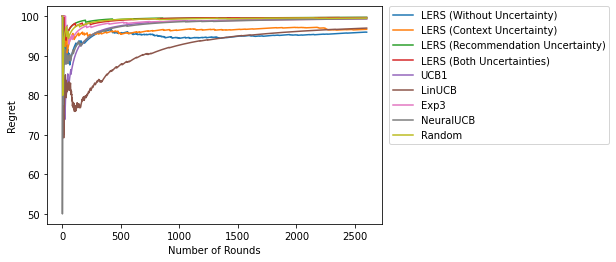

aenn's hit ratio: 64.1419 %
vaenn's hit ratio: 51.0722 %
aebnn's hit ratio: 17.2197 %
vaebnn's hit ratio: 19.201 %
UCB1's hit ratio: 21.2964 %
LinUCB's hit ratio: 26.6938 %
Exp3's hit ratio: 76.6979 %
NeuralUCB's hit ratio: 19.2254 %


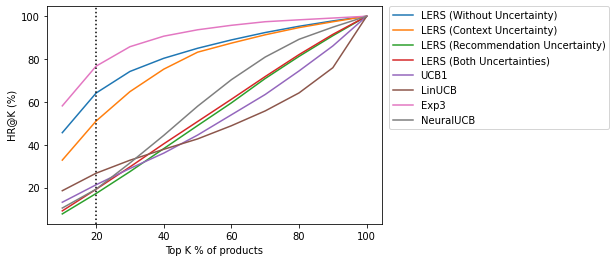

aenn's coverage: 0.8316 %
vaenn's coverage: 0.5218 %
aebnn's coverage: 0.0571 %
vaebnn's coverage: 0.0734 %
UCB1's coverage: 0.1141 %
LinUCB's coverage: 0.636 %
Exp3's coverage: 0.1386 %
NeuralUCB's coverage: 0.1386 %
random's coverage: 0.0978 %


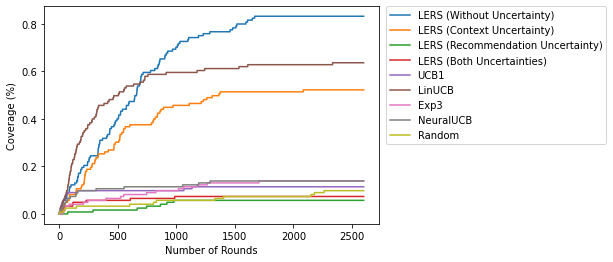

aenn's diversity: 23.9492 %
vaenn's diversity: 31.9648 %
aebnn's diversity: 65.2004 %
vaebnn's diversity: 87.8788 %
UCB1's diversity: 100.0 %
LinUCB's diversity: 100.0 %
Exp3's diversity: 91.6911 %
NeuralUCB's diversity: 69.9902 %
random's diversity: 92.0821 %


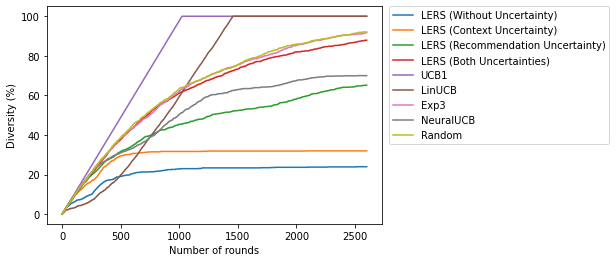

In [4]:
mab_context = np.load('data/mab_context.npy') # mab_latent30
mab_context, mab_context_id, _ = preprocess.trim_cust_for_context_sort(mab_context, cust_id, reward_cust_id)
regret, hr, coverage, diversity, predict_id = \
main(len(mab_context_id), mab_context, mab_context_id, all_reward_pivot, reward_prod_id, \
     regrets_structure_w, hr_structure_w, coverage_structure_w, diversity_structure_w) 

## Context Comparison

### without class weights

[Autoencode streamer-product features]
[Test] change Double to Float
Step [8/8], Reconstructed Loss: 0.0230
product feature: (1023, 32)
streamer feature: (1023, 23)
small streamer-product: (1023, 55)


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


Recommend Ratio: 0.15 %
Accuracy: 96.93 %
Correct: 2522
Regret: 3.07 %
Early Stop times: 35


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


Recommend Ratio: 0.15 %
Accuracy: 96.93 %
Correct: 2522
Regret: 3.07 %
Early Stop times: 35


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


Recommend Ratio: 0.15 %
Accuracy: 96.93 %
Correct: 2522
Regret: 3.07 %
Early Stop times: 35
full's regret: 0.0307
static's regret: 0.0307
temporal's regret: 0.0307


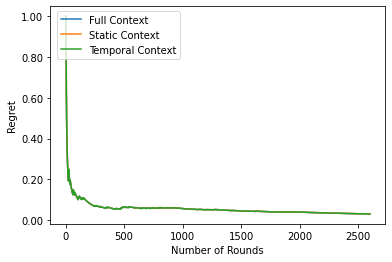

full's hit ratio: 23.31 %
static's hit ratio: 23.31 %
temporal's hit ratio: 23.31 %


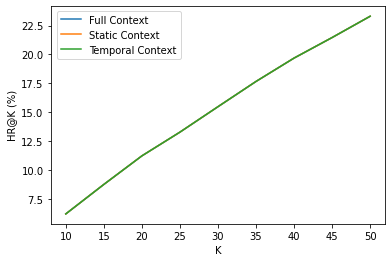

In [2]:
experiments = ['full','static', 'temporal']
mylabels = ['Full Context','Static Context', 'Temporal Context']
fig_name = 'end2end_lers_context_big'
regrets_context, hr_context, all_reward_pivot, cust_id, reward_cust_id, reward_prod_id, topk_context=\
end2end_recommendation.main(experiments, mylabels, fig_name, 2602, 1023, z_dim=20, weight_eps=1)

### with class weights

[Autoencode streamer-product features]
[Test] change Double to Float
Step [8/8], Reconstructed Loss: 0.0230
product feature: (1023, 32)
streamer feature: (1023, 23)
small streamer-product: (1023, 55)
total: 2661846, pos: 12265, neg: 2649581
Weight for class 0: 0.50
Weight for class 1: 108.51


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:28 Time:  0:00:28


Recommend Ratio: 99.88 %
Accuracy: 4.04 %
Correct: 105
Regret: 95.96 %
Early Stop times: 36


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:37 Time:  0:00:37


Recommend Ratio: 99.88 %
Accuracy: 4.04 %
Correct: 105
Regret: 95.96 %
Early Stop times: 36


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:27 Time:  0:00:27


Recommend Ratio: 99.88 %
Accuracy: 4.04 %
Correct: 105
Regret: 95.96 %
Early Stop times: 36
full's regret: 0.9596
static's regret: 0.9596
temporal's regret: 0.9596


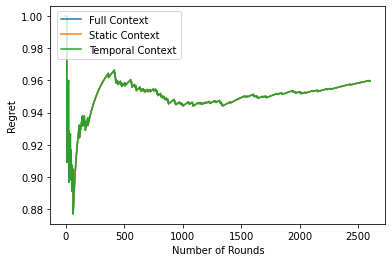

full's hit ratio: 29.87 %
static's hit ratio: 29.87 %
temporal's hit ratio: 29.87 %


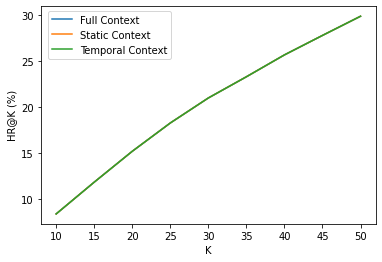

In [3]:
experiments = ['full','static', 'temporal']
mylabels = ['Full Context','Static Context', 'Temporal Context']
fig_name = 'end2end_lers_context_big_weights'
# experiments = ['basket', 'streamer']
# mylabels = ['Customer-Product Context', 'Customer-Streamer Context']
# fig_name = 'end2end_lers_temporal_big_weights'
_, _, _, _, _, _, _ = end2end_recommendation.main(experiments, mylabels, fig_name, 2602, 1023, z_dim=20, weight_eps=1, class_weight = True)

## Temporal Context

### without class weights

[Autoencode streamer-product features]
[Test] change Double to Float
Step [8/8], Reconstructed Loss: 0.0230
product feature: (1023, 32)
streamer feature: (1023, 23)
small streamer-product: (1023, 55)


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:58 Time:  0:00:58


Recommend Ratio: 0.15 %
Accuracy: 96.93 %
Correct: 2522
Regret: 3.07 %
Early Stop times: 35


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:59 Time:  0:00:59


Recommend Ratio: 0.15 %
Accuracy: 96.93 %
Correct: 2522
Regret: 3.07 %
Early Stop times: 35
basket's regret: 0.0307
streamer's regret: 0.0307


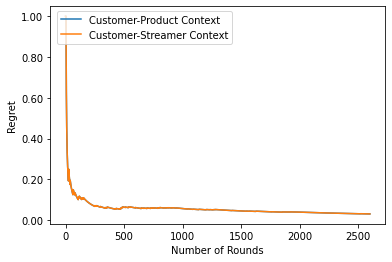

basket's hit ratio: 23.31 %
streamer's hit ratio: 23.31 %


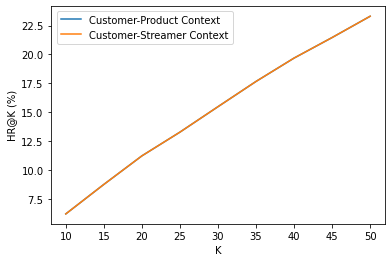

In [10]:
experiments = ['basket', 'streamer']
mylabels = ['Customer-Product Context', 'Customer-Streamer Context']
fig_name = 'end2end_lers_temporal_big'
regrets_temporal, hr_temporal, _, _, _, _, topk_temporal= end2end_recommendation.main(experiments, mylabels, fig_name, 2602, 1023, z_dim=20)

### with class weights

[Autoencode streamer-product features]
[Test] change Double to Float
Step [8/8], Reconstructed Loss: 0.0230
product feature: (1023, 32)
streamer feature: (1023, 23)
small streamer-product: (1023, 55)
total: 2661846, pos: 12265, neg: 2649581
Weight for class 0: 0.50
Weight for class 1: 108.51


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:59 Time:  0:00:59


Recommend Ratio: 99.88 %
Accuracy: 4.04 %
Correct: 105
Regret: 95.96 %
Early Stop times: 36


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:58 Time:  0:00:58


Recommend Ratio: 99.88 %
Accuracy: 4.04 %
Correct: 105
Regret: 95.96 %
Early Stop times: 36
basket's regret: 0.9596
streamer's regret: 0.9596


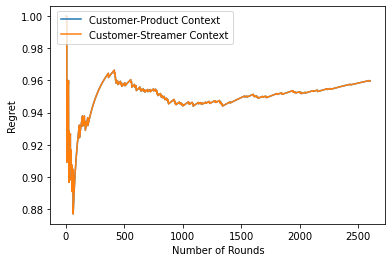

basket's hit ratio: 29.87 %
streamer's hit ratio: 29.87 %


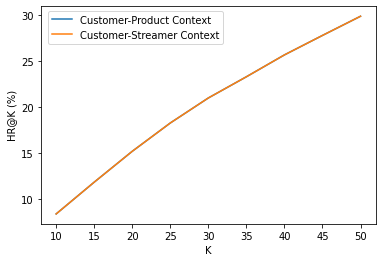

In [11]:
experiments = ['basket', 'streamer']
mylabels = ['Customer-Product Context', 'Customer-Streamer Context']
fig_name = 'end2end_lers_temporal_big_weights'
_, _, _, _, _, _, _= end2end_recommendation.main(experiments, mylabels, fig_name, 2602, 1023, z_dim=20, weight_eps=1, class_weight = True)

## Uncertainty Structure

### without class weights

[Autoencode streamer-product features]
[Test] change Double to Float
Step [8/8], Reconstructed Loss: 0.0230
product feature: (1023, 32)
streamer feature: (1023, 23)
small streamer-product: (1023, 55)


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:37 Time:  0:00:37


Recommend Ratio: 0.15 %
Accuracy: 96.93 %
Correct: 2522
Regret: 3.07 %
Early Stop times: 35


100% (2602 of 2602) |####################| Elapsed Time: 0:00:26 Time:  0:00:26


Recommend Ratio: 0.15 %
Accuracy: 98.00 %
Correct: 2550
Regret: 2.0 %
Early Stop times: 40


  0% (0 of 2602) |                       | Elapsed Time: 0:00:00 ETA:  --:--:--/home/Oring-AI/jambo/Livestream-Ecommerce-Recommender-System/customized/model/autoencoder.py:50: UserWarning:

Using a target size (torch.Size([1, 408])) that is different to the input size (torch.Size([408])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.

100% (2602 of 2602) |####################| Elapsed Time: 0:00:47 Time:  0:00:47


Recommend Ratio: 100.00 %
Accuracy: 0.27 %
Correct: 7
Regret: 99.73 %
Early Stop times: 43


100% (2602 of 2602) |####################| Elapsed Time: 0:00:47 Time:  0:00:47


Recommend Ratio: 100.00 %
Accuracy: 0.35 %
Correct: 9
Regret: 99.65 %
Early Stop times: 40
aenn's regret: 0.0307
vaenn's regret: 0.02
aebnn's regret: 0.9973
vaebnn's regret: 0.9965


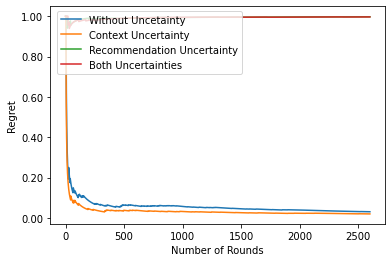

aenn's hit ratio: 23.31 %
vaenn's hit ratio: 14.23 %
aebnn's hit ratio: 3.79 %
vaebnn's hit ratio: 4.07 %


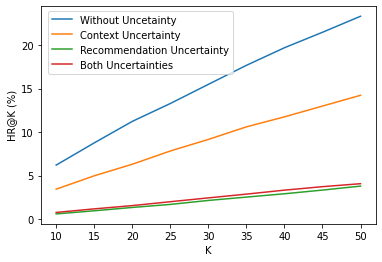

In [12]:
experiments = ['aenn', 'vaenn', 'aebnn', 'vaebnn']
mylabels = ['Without Uncetainty', 'Context Uncertainty', 'Recommendation Uncertainty', 'Both Uncertainties']
fig_name = 'end2end_lers_structure_big'

regrets_structure, hr_structure, all_reward_pivot, cust_id, reward_cust_id, reward_prod_id, topk_structure = end2end_recommendation.main(experiments, mylabels, fig_name, 2602, 1023, z_dim=20, weight_eps=1)